In [38]:
import ujson as json
from collections import defaultdict
import copy
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [39]:
file_list = [249, 866, 434, 672, 184, 938, 212, 140, 546, 347, 633, 556, 205, 340, 533, 513, 130, 5, 777, 650, 20, 414, 543, 419, 813, 561, 52, 310, 698, 314, 61, 961, 198, 714, 974, 746, 753, 881, 377, 564, 270, 835, 371, 471, 692, 560, 905, 411, 38, 721, 297, 559, 803, 649, 955, 409, 380, 976, 815, 500, 480, 660, 438, 454, 718, 306, 996, 154, 620, 772, 498, 155, 787, 332, 770, 767, 196, 981, 115, 722, 609, 289, 231, 959, 124, 17, 222, 653, 214, 181, 940, 426, 685, 244, 807, 496]

In [40]:
with open('./data/docred/rel2id.json', 'r') as fh:
    rel2id = json.load(fh)

id2rel = {}
for rel, idx in rel2id.items():
    id2rel[idx] = rel

with open('./data/docred/valid_scratch.json', 'r') as fh:
    scratch_dataset = json.load(fh)


In [41]:
with open('./data/model_results/96_dev_bilstm_all_results.json', 'r') as fh:
    bilstm_results = json.load(fh)


with open('./data/model_results/96_dev_gain_bert_base_all_results.json', 'r') as fh:
    gain_bert_base_results = json.load(fh)

with open('./data/model_results/96_dev_ssan_roberta_all_results.json', 'r') as fh:
    ssan_results = json.load(fh)

In [42]:
ssan_results = [{'h_idx': res[-3], 't_idx': res[-2], 'r_idx': rel2id[res[-1]], 'title': res[2], 'score': res[1]} for res in ssan_results]

In [43]:
with open('./data/model_results/dev_atlop_roberta_result.json', 'r') as fh:
    altop_roberta_results = json.load(fh)

altop_roberta_results = [res for res in altop_roberta_results if res['title'] in doc_titles]

with open('./data/model_results/dev_docunet_result.json', 'r') as fh:
    docunet_results = json.load(fh)

all_htrs = [(res['h_idx'], res['t_idx'], res['r_idx'], res['title']) for res in gain_bert_base_results]

atlop_roberta_htrs = set([(res['h_idx'], res['t_idx'], rel2id[res['r']], res['title']) for res in altop_roberta_results])
altop_roberta_results = [{'h_idx': res[0], 't_idx': res[1], 'r_idx': res[2], 'title': res[3], 'score': 1} if res in atlop_roberta_htrs else {'h_idx': res[0], 't_idx': res[1], 'r_idx': res[2], 'title': res[3], 'score': 0} for res in all_htrs]

docunet_htrs = set([(res['h_idx'], res['t_idx'], rel2id[res['r']], res['title']) for res in docunet_results])
docunet_results = [{'h_idx': res[0], 't_idx': res[1], 'r_idx': res[2], 'title': res[3], 'score': 1} if res in docunet_htrs else {'h_idx': res[0], 't_idx': res[1], 'r_idx': res[2], 'title': res[3], 'score': 0} for res in all_htrs]


In [44]:
dataset = {'bilstm': bilstm_results,
            'gain_bert_base': gain_bert_base_results,
            'atlop_roberta': altop_roberta_results,
            'ssan': ssan_results,
            'docunet': docunet_results
}

In [45]:
threshold = {
    'gain_bert_base': 0.4427,
    'bilstm': 0.8857,
    'ssan': 0.18446,
}

In [46]:
ori_htrs = set([(data['title'], label['h'], label['t'], rel2id[label['r']])  for data in scratch_dataset for label in data['labels']])

In [47]:
positive_dataset = {}
for dataset_name, single_dataset in dataset.items():
    positive_dataset[dataset_name] = [res for res in single_dataset if (res['title'], res['h_idx'], res['t_idx'], res['r_idx']) in ori_htrs]

大于threshold记1，其余记0

In [48]:
binary_dataset = {}
for dataset_name in ['atlop_roberta', 'docunet']:
    binary_dataset[dataset_name] = positive_dataset[dataset_name]
for dataset_name, single_dataset in positive_dataset.items():
    if dataset_name in threshold:
        binary_dataset[dataset_name] = [{'title': res['title'], 'h_idx': res['h_idx'], 't_idx': res['t_idx'], 'r_idx': res['r_idx'], 'score': int(res['score'] > threshold[dataset_name])} for res in single_dataset]

只保留预测出来的triple

In [49]:
predict_dataset = {}
for dataset_name, single_dataset in dataset.items():
    if dataset_name in threshold:
        predict_dataset[dataset_name] = [res for res in single_dataset if res['score'] > threshold[dataset_name] ]
for dataset_name in ['atlop_roberta', 'docunet']: 
    single_dataset = dataset[dataset_name]
    predict_dataset[dataset_name] = [res for res in single_dataset if res['score'] == 1]

计算模型在Revise 和在Scratch 上的表现

In [ ]:
with open('./data/docred/valid_revise.json', 'r') as fh:
    revise_dataset = json.load(fh)
revise_htrs = set([(data['title'], label['h'], label['t'], rel2id[label['r']])  for data in revise_dataset for label in data['labels']])

In [83]:
dt = {
    "R-P": [],
    "R-R": [],
    "R-F1": [],
    "S-P": [],
    "S-R": [],
    "S-F1": []
}

In [84]:
for dataset_name in ['bilstm', 'gain_bert_base', 'atlop_roberta', 'ssan', 'docunet']:
    single_dataset = predict_dataset[dataset_name]
    pred = set([(res['title'], res['h_idx'], res['t_idx'], res['r_idx']) for res in single_dataset])
    hit_num = len(ori_htrs & pred)
    pred_num = len(pred)
    gold_num = len(ori_htrs)
    p = hit_num / pred_num
    r = hit_num / gold_num
    f1 = 2 * p * r / (p + r)
    dt['S-P'].append(p)
    dt['S-R'].append(r)
    dt['S-F1'].append(f1)

    pred = set([(res['title'], res['h_idx'], res['t_idx'], res['r_idx']) for res in single_dataset])
    hit_num = len(revise_htrs & pred)
    pred_num = len(pred)
    gold_num = len(revise_htrs)
    p = hit_num / pred_num
    r = hit_num / gold_num
    f1 = 2 * p * r / (p + r)

    dt['R-P'].append(p)
    dt['R-R'].append(r)
    dt['R-F1'].append(f1)

In [85]:
df = pd.DataFrame(dt)
df.index = ['BiLSTM', 'GAIN', 'ATLOP', 'SSAN', 'DocuNet']
df = df*100

In [86]:
print(df.round(1).to_latex().replace("\\$", "$").replace("\\_", "_").replace("\\{", "{").replace("\\}", "}").replace("mathbf", "\mathbf"))

\begin{tabular}{lrrrrrr}
\toprule
{} &   R-P &   R-R &  R-F1 &   S-P &   S-R &  S-F1 \\
\midrule
BiLSTM  &  50.2 &  46.7 &  48.4 &  66.6 &  22.8 &  33.9 \\
GAIN    &  60.0 &  56.8 &  58.3 &  81.1 &  28.1 &  41.8 \\
ATLOP   &  66.3 &  59.1 &  62.5 &  90.3 &  29.5 &  44.5 \\
SSAN    &  63.1 &  61.3 &  62.2 &  84.5 &  30.1 &  44.4 \\
DocuNet &  66.9 &  59.9 &  63.2 &  89.1 &  29.3 &  44.1 \\
\bottomrule
\end{tabular}



In [79]:
for dataset_name, single_dataset in predict_dataset.items():
    pred = set([(res['title'], res['h_idx'], res['t_idx'], res['r_idx']) for res in single_dataset])
    hit_num = len(revise_htrs & pred)
    pred_num = len(pred)
    gold_num = len(revise_htrs)
    p = hit_num / pred_num
    r = hit_num / gold_num
    f1 = 2 * p * r / (p + r)
    print (dataset_name, p, r, f1)

bilstm 0.5017699115044247 0.4670510708401977 0.4837883959044369
gain_bert_base 0.6001742160278746 0.5675453047775947 0.5834038950042336
ssan 0.6305084745762712 0.6128500823723229 0.6215538847117794
atlop_roberta 0.6626617375231053 0.5906095551894563 0.6245644599303136
docunet 0.6694290976058932 0.5988467874794069 0.6321739130434783


### Relation Bias

将scratch 数据集中的关系实例按照是否属于top 100 property分类

In [54]:
with open('./data/wikidata/Popular Relations.txt' ,'r') as fh:
    lines = fh.readlines()
popular_relations = [line.strip().split('\t')[0].split(' ')[-1][1:-1] for line in lines]
popular_relations = set(popular_relations) & set(list(rel2id))
unpopular_relations = [rel for rel in rel2id if rel not in popular_relations and rel != 'Na']

In [55]:
ins_with_rel = defaultdict(list)
for data in scratch_dataset:
    for label in data['labels']:
        ins_with_rel[label['r']].append((data['title'], label['h'], label['t'], rel2id[label['r']]))

In [56]:
pop_rel_instances = []
unpop_rel_instances = []
for rel in popular_relations:
    pop_rel_instances += ins_with_rel[rel]
for rel in unpopular_relations:
    unpop_rel_instances += ins_with_rel[rel]

pop_rel_instances = set(pop_rel_instances)
unpop_rel_instances = set(unpop_rel_instances)

In [57]:
pop_rel_scores = defaultdict(list)
unpop_rel_scores = defaultdict(list)

for dataset_name, single_dataset in binary_dataset.items():
    for res in single_dataset:
        if (res['title'], res['h_idx'], res['t_idx'], res['r_idx']) in pop_rel_instances:
            pop_rel_scores[dataset_name].append(res['score'])
        elif (res['title'], res['h_idx'], res['t_idx'], res['r_idx']) in unpop_rel_instances:
            unpop_rel_scores[dataset_name].append(res['score'])

In [58]:
pop_rel_predict = defaultdict(list)
unpop_rel_predict = defaultdict(list)

for dataset_name, single_dataset in predict_dataset.items():
    for res in single_dataset:
        if id2rel[res['r_idx']] in popular_relations:
            pop_rel_predict[dataset_name].append(res['score'])
        else:
            unpop_rel_predict[dataset_name].append(res['score'])

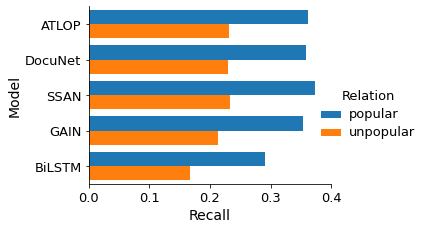

In [67]:
model_names = ['bilstm', 'gain_bert_base', 'atlop_roberta', 'ssan', 'docunet']
model_names = ['atlop_roberta', 'docunet', 'ssan', 'gain_bert_base', 'bilstm']
name_mp = {
    'bilstm': 'BiLSTM',
    'gain_bert_base': 'GAIN',
    'atlop_roberta': 'ATLOP',
    'ssan': 'SSAN',
    'docunet': 'DocuNet'
}
y = []
x = []
hue = []
for name in model_names:
    score =  pop_rel_scores[name] + unpop_rel_scores[name]
    model_name = [name_mp[name]] * len(score)
    clss = ['popular'] * len(pop_rel_scores[name]) + ['unpopular'] * len(unpop_rel_scores[name])

    y += score
    x += model_name
    hue += clss

df = pd.DataFrame({"Model":x, "Recall": y, "Relation": hue})
# plt.figure(figsize=(4, 4))
sns_fig = sns.catplot(y="Model", x="Recall", hue="Relation", data = df, kind='bar', saturation=1.0, height=3, aspect=1.5, ci=None)
# plt.plot()
sns_fig.set_xlabels(fontsize=14)
sns_fig.set_ylabels(fontsize=14)

# sns_fig.set_xticks((0, 0.1, 0.2, 0.3, 0.4))

sns_fig.set_xticklabels(fontsize=13)
sns_fig.set_yticklabels(fontsize=13)
plt.setp(sns_fig.legend.get_title(), fontsize=13)
plt.setp(sns_fig.legend.get_texts(), fontsize=13)

sns_fig.ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
sns_fig.ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

sns_fig.savefig('./figs/model_relation_bias.pdf')


### Entity Bias

In [60]:
with open('./data/wikidata/final_id2popular.json', 'r') as fh:
    id2popular = json.load(fh)
with open('./data/wikidata/final_wiki_ids.json', 'r') as fh:
    wiki_ids = json.load(fh)

In [61]:
with open('./data/docred/dev.json', 'r') as fh:
    dev_dataset = json.load(fh)
doc_titles = [data['title'] for data in dev_dataset]
title2id = {}
for fid, title in enumerate(doc_titles):
    title2id[title] = fid

In [62]:
for dataset_name, single_dataset in binary_dataset.items():
    for res in single_dataset:
        doc_wiki_ids = wiki_ids[title2id[res['title']]]

        h_wiki_ids = doc_wiki_ids[int(res['h_idx'])]
        t_wiki_ids = doc_wiki_ids[int(res['t_idx'])]

        h_popularity = [id2popular[qid] for qid in h_wiki_ids if qid in id2popular]
        t_popularity = [id2popular[qid] for qid in t_wiki_ids if qid in id2popular]

        h_popularity = -1 if len(h_popularity) == 0 else max(h_popularity)
        t_popularity = -1 if len(t_popularity) == 0 else max(t_popularity)

        res['dominant_ent_pop'] = max(h_popularity, t_popularity)
        res['recessive_ent_pop'] = min(h_popularity, t_popularity)

/home/huangqz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


bilstm [37.23583460949464, 85.91424196018377, 171.7748851454824, 397.32618683001533, 652.509954058193] [0.15926493108728942, 0.225114854517611, 0.21439509954058192, 0.2113323124042879, 0.327718223583461]


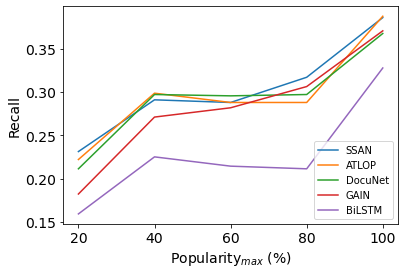

In [66]:
bin_number = 5
model_names = ['ssan', 'atlop_roberta', 'docunet', 'gain_bert_base', 'bilstm'] # 'ssan', 
name_mp = {
    'bilstm': 'BiLSTM',
    'gain_glove': 'GAIN',
    'gain_bert_base': 'GAIN',
    'gain_bert_large': 'GAIN',
    'atlop_roberta': 'ATLOP',
    'ssan': 'SSAN',
    'docunet': 'DocuNet'
}

fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()

# for dataset_name, single_dataset in positive_dataset.items():
for dataset_name in model_names:
    single_dataset = binary_dataset[dataset_name]
    linked_dataset = [res for res in single_dataset if res['dominant_ent_pop'] != -1]
    linked_dataset.sort(key=lambda x: x['recessive_ent_pop'])
    linked_dataset.sort(key=lambda x: x['dominant_ent_pop'])

    ent_pop = [res['dominant_ent_pop'] for res in linked_dataset]
    scores = [res['score'] for res in linked_dataset]
    interval = len(scores) // bin_number
    scores = [np.mean(scores[bin_num*interval: (bin_num + 1)*interval]) for bin_num in range(bin_number)]
    ent_pop = [np.mean(ent_pop[bin_num*interval: (bin_num + 1)*interval]) for bin_num in range(bin_number)]

    x = [20, 40, 60, 80, 100]
    ax1.plot(x, scores, label=name_mp[dataset_name])

ax1.set_xticks(x)
# ax2.scatter(x, ent_pop, c='black', )
ax1.set_xlabel('Popularity$_{max}$ (%)', fontsize=14)
ax1.set_ylabel('Recall', fontsize=14)
ax1.set_xticklabels([20, 40, 60, 80, 100], fontsize=14)

ax1.set_yticklabels([0, 0.15, "0.20", 0.25, "0.30", 0.35], fontsize=14)
# ax2.set_ylabel("Average Popularity")
ax1.legend(loc='center right', bbox_to_anchor=(1.0, 0.2), ncol=1, fontsize=10)

# plt.subplots_adjust(bottom=0.15)
# plt.subplots_adjust(left=0.15)

print(dataset_name, ent_pop, scores)
plt.savefig('./figs/model_entity_bias_max.pdf', bbox_inches='tight')

 

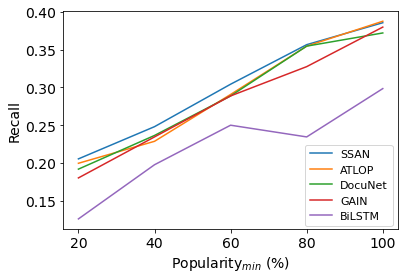

In [65]:
bin_number = 5
model_names = ['ssan', 'atlop_roberta', 'docunet', 'gain_bert_base', 'bilstm']
name_mp = {
    'bilstm': 'BiLSTM',
    'gain_glove': 'GAIN',
    'gain_bert_base': 'GAIN',
    'gain_bert_large': 'GAIN',
    'atlop_roberta': 'ATLOP',
    'ssan': 'SSAN',
    'docunet': 'DocuNet'
}

# for dataset_name, single_dataset in positive_dataset.items():
for dataset_name in model_names:
    # single_dataset = positive_dataset[dataset_name]
    single_dataset = binary_dataset[dataset_name]
    linked_dataset = [res for res in single_dataset if res['recessive_ent_pop'] != -1]
    linked_dataset.sort(key=lambda x: x['dominant_ent_pop'])
    linked_dataset.sort(key=lambda x: x['recessive_ent_pop'])

    ent_pop = [res['recessive_ent_pop'] for res in linked_dataset]
    scores = [res['score'] for res in linked_dataset]
    interval = len(scores) // bin_number
    scores = [np.mean(scores[bin_num*interval: (bin_num + 1)*interval]) for bin_num in range(bin_number)]
    ent_pop = [np.mean(ent_pop[bin_num*interval: (bin_num + 1)*interval]) for bin_num in range(bin_number)]

    x = [20, 40, 60, 80, 100]
    plt.plot(x, scores, label=name_mp[dataset_name])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Popularity$_{min}$ (%)', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.legend(loc='center right', bbox_to_anchor=(1., 0.2), ncol=1, fontsize=11)
# plt.subplots_adjust(bottom=0.15)
# plt.subplots_adjust(left=0.15)
plt.xticks(x)
plt.savefig('./figs/model_entity_bias_min.pdf', bbox_inches='tight')
    # print(dataset_name, ent_pop, scores)
 